In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble']=r"\usepackage{bm}"
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[0])

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [ ]:
import exciting_environments as excenvs

import exciting_exciting_systems
from exciting_exciting_systems.models import NeuralEulerODEPendulum, NeuralODEPendulum, NeuralEulerODE, NeuralEulerODECartpole
from exciting_exciting_systems.models.model_utils import simulate_ahead_with_env
from exciting_exciting_systems.models.model_training import ModelTrainer
from exciting_exciting_systems.excitation import loss_function, Exciter

from exciting_exciting_systems.utils.density_estimation import (
    update_density_estimate_single_observation, update_density_estimate_multiple_observations, DensityEstimate
)
from exciting_exciting_systems.utils.signals import aprbs
from exciting_exciting_systems.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction, plot_model_performance
)
from exciting_exciting_systems.evaluation.experiment_utils import (
    get_experiment_ids, load_experiment_results, quick_eval, evaluate_experiment_metrics, evaluate_algorithm_metrics, evaluate_metrics
)

---

In [ ]:
# setup PRNG
key = jax.random.PRNGKey(seed=33) # 21)

data_key, model_key, loader_key, key = jax.random.split(key, 4)
data_rng = PRNGSequence(data_key)

In [ ]:
env_params = dict(
    batch_size=1,
    tau=2e-2,
    max_force=10,
    static_params={
        "mu_p": 0.002,
        "mu_c": 0.5,
        "l": 0.5,
        "m_p": 0.1,
        "m_c": 1,
        "g": 9.81,
    },
    physical_constraints={
        "deflection": 2.4,
        "velocity": 8,
        "theta": jnp.pi,
        "omega": 8,
    },
    env_solver=diffrax.Tsit5(),
)
env = excenvs.make(
    env_id="CartPole-v0",
    batch_size=env_params["batch_size"],
    action_constraints={"force": env_params["max_force"]},
    physical_constraints=env_params["physical_constraints"],
    static_params=env_params["static_params"],
    solver=env_params["env_solver"],
    tau=env_params["tau"],
)

In [ ]:
obs, state = env.reset()
obs = obs[0]

n_steps = 999

# actions = aprbs(n_steps, batch_size, 1, 10, next(data_rng))[0]


actions = jnp.ones((1000, 1))
actions = actions.at[10:].set(0)

In [ ]:
observations, _ = simulate_ahead_with_env(env, obs, state, actions)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=env.tau,
    obs_labels=[r"$p_x$", r"$v_x$", r"$\theta$", r"$\omega$"],
    action_labels=[r"$F$"],
);
plt.show()

---

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/exciting-exciting-systems/eval/results/dmpe/cart_pole")

In [ ]:
params, observations, actions, model = load_experiment_results(get_experiment_ids(results_path)[7], results_path, NeuralEulerODECartpole)

In [ ]:
N = 15_000

plot_model_performance(
    model, observations[N:N+500], actions[N:N+499], env.tau, env.obs_description, env.action_description
)

In [ ]:
actions = jnp.ones((100, 1))
actions = actions.at[10:].set(0)

actions = actions.at[50:].set(-1)
actions = actions.at[60:].set(+1)

observations, _ = simulate_ahead_with_env(env, obs, state, actions)

plot_model_performance(
    model, observations, actions, env.tau, env.obs_description, env.action_description
)

- iterate through all the runs and test the models on random trajectories:

could be done in theory at least

The question would be:

model good -> data good
data good -> model good

probably both?


**jsd on the runs:**

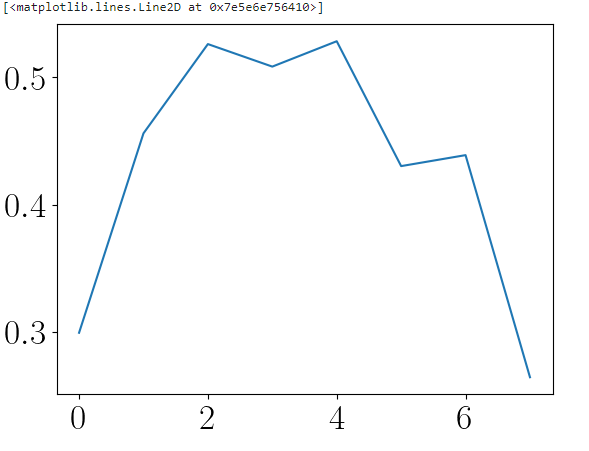


In [ ]:
from exciting_exciting_systems.models.model_utils import simulate_ahead

In [ ]:
obs, state = env.reset()
obs = obs[0]


errors = []
data_rng = PRNGSequence(jax.random.PRNGKey(seed=33))


for exp_idx, identifier in enumerate(get_experiment_ids(results_path)):
    params, observations, actions, model = load_experiment_results(identifier, results_path, NeuralEulerODECartpole)

    errors_for_run = []
    
    for i in tqdm(range(1000)):       
        actions = aprbs(50, 1, 1, 10, next(data_rng))[0]
        
        observations, _ = simulate_ahead_with_env(env, obs, state, actions)
    
        pred_observations = simulate_ahead(model, observations[0, :], actions, env.tau)
    
        mse = np.mean(np.linalg.norm(observations - pred_observations, axis=1), axis=0)
        errors_for_run.append(mse)

    errors.append(errors_for_run)

In [ ]:
plt.plot(np.mean(np.array(errors), axis=1))

... use similar setup to model learning but with cross validation